# Imports des bibliothèques

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt
# Pour les réseaux de neurones feed-forward
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Pour le découpage des échantillons
from sklearn.model_selection import train_test_split

# Fonctions de base


In [11]:
def genere_X(n,trou,corrupt):
  #  Si trou <= 0 : Genere un echantillon uniforme sur [0,1]
  #  Si (0< trou <0.5) : Genere un échantillon dont le support est dans [0,trou] U [1-trou, 1]
  #  Si (0< trou <0.5) et (corrupt != 0) : ajoute un example 0.5
    X = np.zeros(n)

    if (trou > 0) & (trou < 0.5):
        n2 = math.floor(n/2)
        X[0:n2] =  np.random.uniform(0, trou, n2)
        X[n2:] = np.random.uniform(1- trou , 1, n2)
        if (corrupt != 0):
            X[np.random.randint(0, n)] = 0.5
    else :
        X = np.random.uniform(0, 1, n)

    return X.reshape(-1, 1)
################################################################
def genere_Y(X,f,corrupt_value, noise_variance):
    # Genere Y suivant la fonction cosinus de frequence f
    # Si une entrée de X vaut exactement 0.5, le Y correspondant vaut corrupt_value
    Y =  np.cos(f*X) + noise_variance * np.random.randn(X.shape[0], 1)

    indices = np.where(X == 0.5)[0]
    if indices.size > 0:
        Y[indices] = corrupt_value

    return Y
################################################################
def genere_NN_dense(X,taille_output,largeur,profondeur):
    # X : sert à donner la taille de la couche d'entrée
    # taille_output : donne la taille de la couche de sortie
    # largeur : c'est la largeur des couches cachées
    # profondeur : Le nombre de couches cachées

    model = Sequential()   #crée un réseau de neurone vide
    for i in range(profondeur):      # crée les couches cachées
        model.add(Dense(largeur, activation='relu'))   #, kernel_initializer=HeNormal()

    model.add(Dense(1, activation='linear'))  #crée la couche de sortie

    y = model(X) # Pour donner la taille de la première couche

    return model
################################################################
def optimize_NN_dense(X,Y,taille_output,largeur,profondeur):
    # X : les exemples en entrée
    # Y : les exemples en sortie
    # taille_output : donne la taille de la couche de sortie
    # largeur : c'est la largeur des couches cachées
    # profondeur : Le nombre de couches cachées


    # Création du réseau de neurone (initialisation à 0)
    model = genere_NN_dense(X,taille_output,largeur,profondeur)

    # Compilation du modèle (pour nous : définition de l'optimiseur et de la loss)
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Callbacks pour une convergence robuste
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, verbose=1)

    # Optimisation des paramètres du modèle
    history = model.fit(X, Y, epochs=500, batch_size=32, validation_split=0.2,callbacks=[reduce_lr], verbose=0)
    return model, history
################################################################

# Génère un echantillon

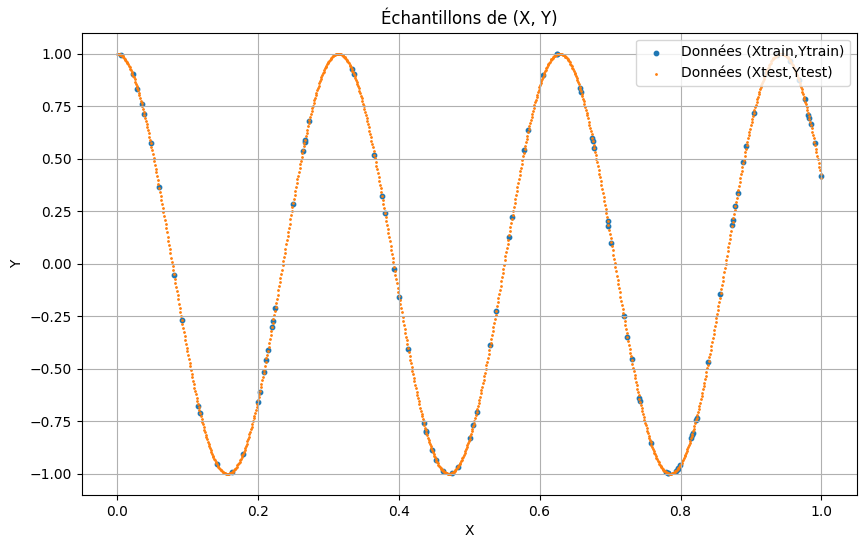

In [12]:
# caracteristiques de la distribution (X,Y)
f = 20       # Plus la frequence est élevée plus le problème est difficile
trou = -1     # 0 ou dans (0,0.5)
corrupt = 0    # Pour visualiser que le réseau peut prendre n'importe quelle valeur en 0.5
corrupt_value = 10    # idem
noise_variance = 0.   # variance du bruit

# Définir la taille de l'échantillon
n = 100  # Nombre de points dans l'échantillon

# Génére Xtrain, Ytrain
Xtrain = genere_X(n,trou,corrupt )
Ytrain = genere_Y(Xtrain,f,corrupt_value,noise_variance)

# Génère Xtest, Ytest
Xtest =  np.linspace(0, 1, 1000).reshape(-1, 1)
Ytest = genere_Y(Xtest,f,corrupt_value,noise_variance)

# Afficher (Xtrain,Ytrain)
plt.figure(figsize=(10, 6))
plt.scatter(Xtrain, Ytrain, label='Données (Xtrain,Ytrain)', alpha=1, s=10)
plt.scatter(Xtest, Ytest, label='Données (Xtest,Ytest)', alpha=1, s=1)
plt.title("Échantillons de (X, Y)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Génère et optimize plusieurs Multi-Layer-Perceptron (MLP), de différentes largeurs


In [5]:
# architecture du réseau
largeurs = [10, 20, 30, 40, 50, 60, 70 , 80, 90, 100, 200, 400  ]
profondeur = 6
taille_output = 1
# Dictionnaire pour mémoriser les résultats
resultats = {}

for largeur in largeurs:
    print(f"Optimisation pour largeur = {largeur}")
    model , history = optimize_NN_dense(Xtrain, Ytrain, taille_output, largeur, profondeur)

    loss_train, mae_train = model.evaluate(Xtrain, Ytrain)
    loss_test, mae_test = model.evaluate(Xtest, Ytest)
    nb_params = model.count_params()

    resultats[largeur] = {
        'model': model,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'loss_train': loss_train,
        'loss_test': loss_test,
        'history': history,
        'nb_params': nb_params
    }





Epoch 462: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.7849e-04 - mae: 0.0145 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9352e-04 - mae: 0.0149 
Optimisation pour largeur = 50

Epoch 281: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.

Epoch 331: ReduceLROnPlateau reducing learning rate to 4.9999996554106475e-05.

Epoch 381: ReduceLROnPlateau reducing learning rate to 4.999999509891496e-06.

Epoch 431: ReduceLROnPlateau reducing learning rate to 4.999999418942025e-07.

Epoch 481: ReduceLROnPlateau reducing learning rate to 4.999999418942025e-08.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0284 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - mae: 0.0204     
Optimisation pour largeur = 60

Epoch 277: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.

Epoch 480: ReduceLROnPlateau reducing learning rate to 4.9999996554106475e-05.
4/4 ━━━━━━━━━━━━━━━━

# Affichage des performances


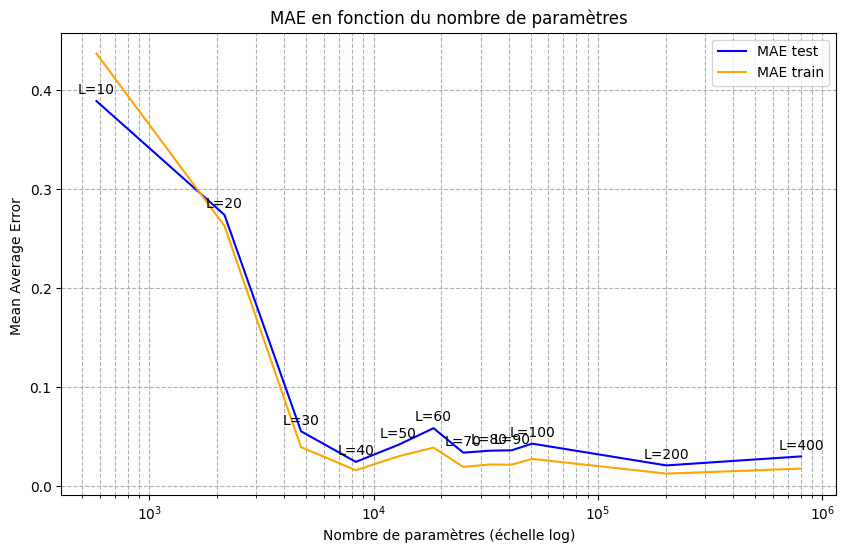

In [6]:

# Préparation des données
largeurs = list(resultats.keys())
nb_params = [resultats[l]['nb_params'] for l in largeurs]
mae_test = [resultats[l]['mae_test'] for l in largeurs]
mae_train = [resultats[l]['mae_train'] for l in largeurs]

# Création du plot
plt.figure(figsize=(10, 6))
plt.plot(nb_params, mae_test, c='blue', label='MAE test')
plt.plot(nb_params, mae_train, c='orange', label='MAE train')

# Échelle logarithmique pour l'abscisse
plt.xscale('log')
plt.xlabel('Nombre de paramètres (échelle log)')
plt.ylabel('Mean Average Error ')
plt.title('MAE en fonction du nombre de paramètres')

# Annoter chaque point avec la largeur correspondante
for i, largeur in enumerate(largeurs):
    plt.annotate(f'L={largeur}', (nb_params[i], mae_test[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()


# Affiche du résultat pour un modèle


largeur =   100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


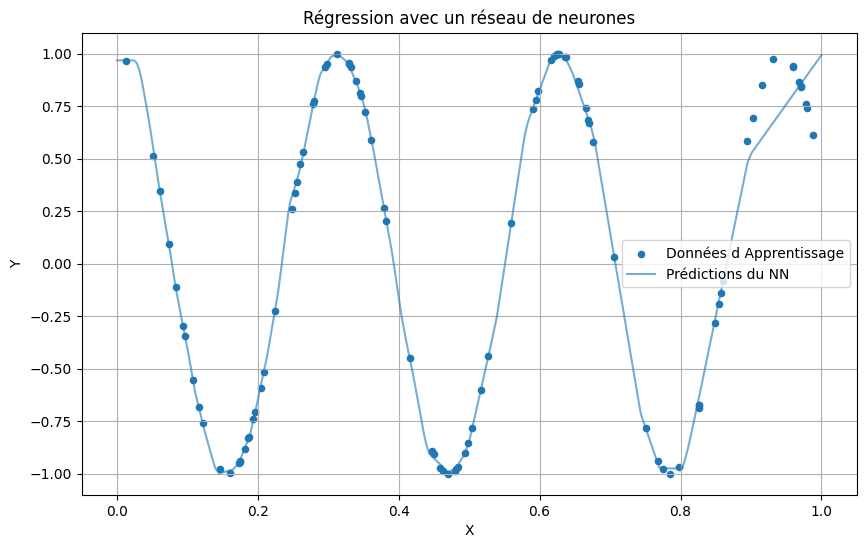

In [7]:
largeur = largeurs[9]
print('largeur =  ', largeur)
model = resultats[largeur]['model']

# Affichage des fonctions
Y_test_pred = model.predict(Xtest)

# Graphique : données réelles vs prédictions
plt.figure(figsize=(10, 6))
plt.scatter(Xtrain, Ytrain, label='Données d Apprentissage', alpha=1, s=20)
plt.plot(Xtest, Y_test_pred, label='Prédictions du NN', alpha=0.6)
plt.title("Régression avec un réseau de neurones")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()


# Affichage de history pour un model


largeur =   100


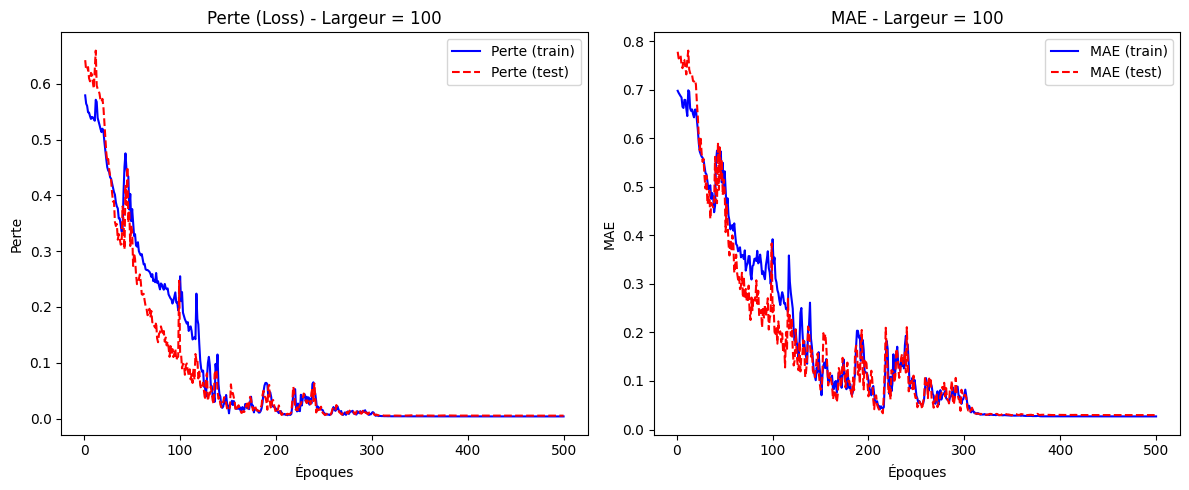

In [9]:

# Choisis une largeur (exemple : 64)
largeur = largeurs[9]
print('largeur =  ', largeur)
history = resultats[largeur]['history']

# Récupère les métriques
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)

# Crée le plot
plt.figure(figsize=(12, 5))

# Courbes de perte (loss)
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Perte (train)')
plt.plot(epochs, val_loss, 'r--', label='Perte (test)')
plt.title(f'Perte (Loss) - Largeur = {largeur}')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

# Courbes de MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'b-', label='MAE (train)')
plt.plot(epochs, val_mae, 'r--', label='MAE (test)')
plt.title(f'MAE - Largeur = {largeur}')
plt.xlabel('Époques')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()